In [1]:
import pandas as pd
import numpy as np

import torch
import time
import json

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_recall_fscore_support, classification_report

# Dataset Preprocessing

In [2]:
CSV_PATHS = [
  "data/Emotion NLP/goemotions_1.csv",
  "data/Emotion NLP/goemotions_2.csv",
  "data/Emotion NLP/goemotions_3.csv",
]

KEPT_LABELS = ["joy", "sadness", "anger", "fear", "surprise", "love"]

TARGET_MIN_SAMPLES = 1000
TARGET_MAX_SAMPLES = 3000
MAX_LABEL_FRACTION = 0.30  # no emotion should dominate >30%

RANDOM_SEED = 42

In [3]:
dfs = [pd.read_csv(path) for path in CSV_PATHS]
df = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(df)} total samples")

Loaded 211225 total samples


In [4]:
if "example_very_unclear" in df.columns:
  before = len(df)
  df = df[df["example_very_unclear"] == False]
  print(f"Dropped {before - len(df)} unclear samples")

Dropped 3411 unclear samples


In [5]:
keep_cols = ["text"] + KEPT_LABELS
df = df[keep_cols]

In [6]:
label_sum = df[KEPT_LABELS].sum(axis=1)
before = len(df)
df = df[label_sum > 0]
print(f"Dropped {before - len(df)} zero-label samples")

Dropped 169556 zero-label samples


In [7]:
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [8]:
def label_frequencies(frame):
  return frame[KEPT_LABELS].sum() / len(frame)

In [9]:
while True:
  freqs = label_frequencies(df)
  max_label = freqs.idxmax()
  max_frac = freqs[max_label]

  if max_frac <= MAX_LABEL_FRACTION:
    break

  # find rows dominated only by the max label
  mask = (df[max_label] == 1) & (df[KEPT_LABELS].sum(axis=1) == 1)
  removable = df[mask]

  if len(removable) == 0:
    break

  # remove a small chunk
  drop_n = min(50, len(removable))
  drop_idx = removable.sample(n=drop_n, random_state=RANDOM_SEED).index
  df = df.drop(drop_idx)
  

print("Final label distribution:")
print(df[KEPT_LABELS].sum().sort_values(ascending=False))

Final label distribution:
love        8191
anger       8084
joy         7983
sadness     6758
surprise    5514
fear        3197
dtype: int64


In [10]:
if len(df) > TARGET_MAX_SAMPLES:
  df = df.sample(n=TARGET_MAX_SAMPLES, random_state=RANDOM_SEED)

elif len(df) < TARGET_MIN_SAMPLES:
  print("Warning: dataset smaller than target minimum")

print(f"Final dataset size: {len(df)}")

Final dataset size: 3000


In [11]:
OUTPUT_PATH = "data/Emotion NLP/goemotions_eval_set.csv"
df.to_csv(OUTPUT_PATH, index=False)

print(f"Saved frozen evaluation set → {OUTPUT_PATH}")

Saved frozen evaluation set → data/Emotion NLP/goemotions_eval_set.csv


# Inference

In [12]:
class TextDataset(Dataset):
  def __init__(self, texts, tokenizer, max_length=128):
    self.texts = texts
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    return self.tokenizer(
      self.texts[idx],
      padding="max_length",
      truncation=True,
      max_length=self.max_length,
      return_tensors="pt"
    )


In [13]:
# quick inference
def run_inference(model_name, model, tokenizer, texts, threshold=0.5):
  print(f"\nRunning inference: {model_name}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Device: {device}")

  model.to(device)
  model.eval()

  inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits)  # multi-label probabilities
    preds = (probs >= threshold).int()
    
  return preds, probs

possibly remove the batching?  
 |  
 v  

In [14]:
def run_inference_with_timing(model_name, model, dataloader, n_samples, threshold=0.5, batch_size=16):
  print(f"\nRunning inference: {model_name}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Device: {device}")

  model.to(device)
  model.eval()

  all_probs = []

  start_time = time.perf_counter()

  with torch.no_grad():
    for batch in dataloader:
      batch = {k: v.squeeze(1).to(device) for k, v in batch.items()}
      outputs = model(**batch)
      logits = outputs.logits
      probs = torch.sigmoid(logits)
      all_probs.append(probs.cpu().numpy())

  end_time = time.perf_counter()

  probs = np.vstack(all_probs)

  preds = (probs >= threshold).astype(int)

  timing = {
    "model": model_name,
    "device": str(device),
    "batch_size": batch_size,
    "num_samples": n_samples,
    "total_inference_time_sec": round(end_time - start_time, 3),
    "avg_time_per_sample_ms": round(
      (end_time - start_time) / n_samples * 1000, 3
    )
  }

  return preds, probs, timing


In [15]:
def save_nlp_emotion_res(model_name, texts, labels, preds, probs, out_dir):
  out_df = pd.DataFrame({
    "text": texts
  })

  for i, label in enumerate(labels):
    out_df[f"prob_{label}"] = probs[:, i]
    out_df[f"pred_{label}"] = preds[:, i]

  # Save predictions
  pred_path = f"{out_dir}/{model_name}_predictions.csv"
  out_df.to_csv(pred_path, index=False)

In [16]:
def save_nlp_emotion_timing(model_name, timing, out_dir):
  timing_path = f"{out_dir}/{model_name}_timing.json"
  with open(timing_path, "w") as f:
    json.dump(timing, f, indent=2)

In [17]:
DISTIL_LABELS = ["sadness", "joy", "love", "anger", "fear", "surprise"]
ROBERTA_LABELS = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

MODEL_DATA = {
  "distilbert": ["bhadresh-savani/distilbert-base-uncased-emotion", DISTIL_LABELS],
  "roberta": ["cardiffnlp/twitter-roberta-base-emotion-multilabel-latest", ROBERTA_LABELS],
}

In [18]:
BATCH_SIZE = 16
THRESHOLD = 0.5
MAX_LENGTH = 128

In [19]:
PROCESSED_DATA_PATH = "data/Emotion NLP/goemotions_eval_set.csv"
OUTPUT_DIR = "data/Emotion NLP/results/"

In [20]:
goemotions_processed_df = pd.read_csv(PROCESSED_DATA_PATH)
goemotions_texts = goemotions_processed_df["text"].tolist()

n_goemotions_samples = len(goemotions_processed_df)
print(f"Loaded {n_goemotions_samples} samples")

Loaded 3000 samples


In [21]:
# Load tokenizer
distil_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Load model
distil_model = DistilBertForSequenceClassification.from_pretrained(
  "bhadresh-savani/distilbert-base-uncased-emotion",
  problem_type="multi_label_classification",  # for multi-label
  num_labels=len(DISTIL_LABELS)
)

In [22]:
# Load tokenizer
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Load model
roberta_model = RobertaForSequenceClassification.from_pretrained(
  "cardiffnlp/twitter-roberta-base-emotion-multilabel-latest",
  problem_type="multi_label_classification",
  num_labels=len(ROBERTA_LABELS)
)

## Sanity Check

### Without Timing

In [23]:
print(DISTIL_LABELS)
run_inference("distilbert", distil_model, distil_tokenizer, ["I am so happy today!", "This is terrible..."])

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Running inference: distilbert
Device: cpu


(tensor([[0, 1, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0]], dtype=torch.int32),
 tensor([[0.2172, 0.9986, 0.2412, 0.1349, 0.0895, 0.1017],
         [0.9974, 0.1571, 0.0907, 0.4971, 0.2588, 0.0890]]))

In [24]:
print(ROBERTA_LABELS)
run_inference("roberta", roberta_model, roberta_tokenizer, ["I am so happy today!", "This is terrible..."])

['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

Running inference: roberta
Device: cpu


(tensor([[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
         [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]], dtype=torch.int32),
 tensor([[0.0148, 0.0433, 0.0136, 0.0122, 0.9900, 0.6960, 0.8425, 0.0085, 0.0150,
          0.0384, 0.1132],
         [0.9562, 0.0266, 0.9608, 0.6311, 0.0089, 0.0081, 0.0064, 0.1003, 0.5182,
          0.0625, 0.0075]]))

### With Timing

In [25]:
SANITY_N = 5
goemotions_sanity_df = goemotions_processed_df.head(SANITY_N)
goemotions_sanity_texts = goemotions_sanity_df["text"].tolist()

In [26]:
sanity_goemotions_processed_distil_dataset = TextDataset(goemotions_sanity_texts, distil_tokenizer)
sanity_distil_dataloader = DataLoader(sanity_goemotions_processed_distil_dataset, batch_size=BATCH_SIZE)

sanity_goemotions_processed_roberta_dataset = TextDataset(goemotions_sanity_texts, roberta_tokenizer)
sanity_roberta_dataloader = DataLoader(sanity_goemotions_processed_roberta_dataset, batch_size=BATCH_SIZE)

In [27]:
preds, probs, timing = run_inference_with_timing(
  "distilbert-santity",
  distil_model,
  sanity_distil_dataloader,
  n_goemotions_samples
)

print("Probabilities shape:", probs.shape)
print("Sample probabilities:\n", probs[:2])

print("Sample predictions:\n", preds[:2])

for i in range(goemotions_sanity_df.shape[0]):
  print("\nTEXT:", goemotions_sanity_texts[i])
  for j, label in enumerate(DISTIL_LABELS):
    print(f"{label:10s} → {probs[i][j]:.3f}")



Running inference: distilbert-santity
Device: cpu
Probabilities shape: (5, 6)
Sample probabilities:
 [[0.9964663  0.1493925  0.05684914 0.25949445 0.6377073  0.08722472]
 [0.57768834 0.7492968  0.03682164 0.9190556  0.71199644 0.03879093]]
Sample predictions:
 [[1 0 0 0 1 0]
 [1 1 0 1 1 0]]

TEXT: This, in top of my already terrible mental health, is the reason why I'm severely underweight and need help.
sadness    → 0.996
joy        → 0.149
love       → 0.057
anger      → 0.259
fear       → 0.638
surprise   → 0.087

TEXT: We don't know anything yet till it happens. It's great to see everything think they know the eliminations order.....lol. you will be shooked
sadness    → 0.578
joy        → 0.749
love       → 0.037
anger      → 0.919
fear       → 0.712
surprise   → 0.039

TEXT: How poignant.
sadness    → 0.256
joy        → 0.894
love       → 0.556
anger      → 0.850
fear       → 0.057
surprise   → 0.152

TEXT: Loved dropping in from the crack in the ceiling and going out in a blaze 

In [28]:
preds, probs, timing = run_inference_with_timing(
  "roberta-sanity",
  roberta_model,
  sanity_roberta_dataloader,
  n_goemotions_samples
)

print("Probabilities shape:", probs.shape)
print("Sample probabilities:\n", probs[:2])

print("Sample predictions:\n", preds[:2])

for i in range(goemotions_sanity_df.shape[0]):
  print("\nTEXT:", goemotions_sanity_texts[i])
  for j, label in enumerate(DISTIL_LABELS):
    print(f"{label:10s} → {probs[i][j]:.3f}")


Running inference: roberta-sanity
Device: cpu
Probabilities shape: (5, 11)
Sample probabilities:
 [[0.07512293 0.03976237 0.17263333 0.72579306 0.01285184 0.01303598
  0.03384648 0.6592022  0.9587615  0.01310243 0.01232171]
 [0.02888189 0.3025471  0.03123977 0.04462678 0.9852583  0.12936689
  0.54414463 0.00778534 0.01056351 0.29578766 0.08114873]]
Sample predictions:
 [[0 0 0 1 0 0 0 1 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]]

TEXT: This, in top of my already terrible mental health, is the reason why I'm severely underweight and need help.
sadness    → 0.075
joy        → 0.040
love       → 0.173
anger      → 0.726
fear       → 0.013
surprise   → 0.013

TEXT: We don't know anything yet till it happens. It's great to see everything think they know the eliminations order.....lol. you will be shooked
sadness    → 0.029
joy        → 0.303
love       → 0.031
anger      → 0.045
fear       → 0.985
surprise   → 0.129

TEXT: How poignant.
sadness    → 0.009
joy        → 0.044
love       → 0.021
anger 

## Full Inference

In [29]:
goemotions_processed_distil_dataset = TextDataset(goemotions_texts, distil_tokenizer)
distil_dataloader = DataLoader(goemotions_processed_distil_dataset, batch_size=BATCH_SIZE)

goemotions_processed_roberta_dataset = TextDataset(goemotions_texts, roberta_tokenizer)
roberta_dataloader = DataLoader(goemotions_processed_roberta_dataset, batch_size=BATCH_SIZE)

In [30]:
model_name = "distilbert-goemotions"
distil_preds, distil_probs, distil_timing = run_inference_with_timing(
  model_name,
  distil_model,
  distil_dataloader,
  n_goemotions_samples
)
save_nlp_emotion_res(model_name, 
                     goemotions_texts, 
                     DISTIL_LABELS, 
                     distil_preds, 
                     distil_probs,
                     OUTPUT_DIR)
save_nlp_emotion_timing(model_name, distil_timing, OUTPUT_DIR)



Running inference: distilbert-goemotions
Device: cpu


In [32]:
model_name = "roberta-goemotions"
roberta_preds, roberta_probs, roberta_timing = run_inference_with_timing(
  model_name,
  roberta_model,
  roberta_dataloader,
  n_goemotions_samples
)
save_nlp_emotion_res(model_name,
                     goemotions_texts, 
                     ROBERTA_LABELS, 
                     roberta_preds, 
                     roberta_probs,
                     OUTPUT_DIR)
save_nlp_emotion_timing(model_name, roberta_timing, OUTPUT_DIR)


Running inference: roberta-goemotions
Device: cpu


# Evaluation

In [33]:
def evaluate_multilabel(
  df_preds,
  df_gold,
  labels,
  threshold=0.5):
  """
  df_preds: dataframe with conf_<label> columns
  df_gold: dataframe with true <label> columns
  labels: list of labels to evaluate
  """

  # Build prediction matrix
  y_pred = np.vstack([
    (df_preds[f"conf_{lbl}"] >= threshold).astype(int)
    for lbl in labels
  ]).T

  # Build gold matrix
  y_true = df_gold[labels].values

  # Macro + micro
  macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
  )

  micro_p, micro_r, micro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
  )

  overall = pd.DataFrame([{
    "macro_precision": macro_p,
    "macro_recall": macro_r,
    "macro_f1": macro_f1,
    "micro_precision": micro_p,
    "micro_recall": micro_r,
    "micro_f1": micro_f1
  }])

  # Per-label metrics
  per_label = []
  for i, lbl in enumerate(labels):
    p, r, f1, _ = precision_recall_fscore_support(
      y_true[:, i],
      y_pred[:, i],
      average="binary",
      zero_division=0
    )
    per_label.append({
      "label": lbl,
      "precision": p,
      "recall": r,
      "f1": f1
    })

  per_label_df = pd.DataFrame(per_label)

  return overall, per_label_df


In [34]:
df_distil_preds = pd.read_csv("data/Emotion NLP/results/distilbert_predictions.csv")
df_gold = pd.read_csv("data/Emotion NLP/goemotions_eval_set.csv")

distil_overall, distil_per_label = evaluate_multilabel(
  df_preds=df_distil_preds,
  df_gold=df_gold,
  labels=KEPT_LABELS,
  threshold=0.5
)

print("DistilBERT - Overall")
print(distil_overall)

print("\nDistilBERT - Per emotion F1")
print(distil_per_label.sort_values("f1"))


KeyError: 'conf_joy'

In [ ]:
def collapse_roberta_predictions(
  df_roberta,
  mapping,
  threshold=0.5):
  """
  Converts RoBERTa predictions into 6-label emotion space
  """

  df_out = df_roberta[["id", "text"]].copy()

  for target_label, source_labels in mapping.items():
    conf_cols = [f"conf_{lbl}" for lbl in source_labels]

    # Max confidence across mapped labels
    df_out[f"conf_{target_label}"] = df_roberta[conf_cols].max(axis=1)

    # Binary prediction
    df_out[f"pred_{target_label}"] = (
      df_out[f"conf_{target_label}"] >= threshold
    ).astype(int)

  return df_out


In [ ]:
ROBERTA_TO_6 = {
  "anger": ["anger", "disgust"],
  "fear": ["fear", "pessimism"],
  "joy": ["joy", "optimism"],
  "love": ["love", "trust"],
  "sadness": ["sadness"],
  "surprise": ["surprise", "anticipation"]
}


df_roberta_preds = pd.read_csv("data/Emotion NLP/results/roberta_predictions.csv")

df_roberta_6 = collapse_roberta_predictions(
  df_roberta_preds,
  ROBERTA_TO_6,
  threshold=0.5
)

df_roberta_6.head()

roberta_overall, roberta_per_label = evaluate_multilabel(
  df_preds=df_roberta_6,
  df_gold=df_gold,
  labels=KEPT_LABELS,
  threshold=0.5
)

print("RoBERTa - Overall")
print(roberta_overall)

print("\nRoBERTa - Per emotion F1")
print(roberta_per_label.sort_values("f1"))


RoBERTa - Overall
   macro_precision  macro_recall  macro_f1  micro_precision  micro_recall  \
0         0.518823       0.70346  0.577528         0.492351        0.7312   

   micro_f1  
0  0.588463  

RoBERTa - Per emotion F1
      label  precision    recall        f1
3      fear   0.368664  0.565371  0.446304
4  surprise   0.619632  0.446903  0.519280
0       joy   0.388453  0.876206  0.538272
2     anger   0.465442  0.873563  0.607306
1   sadness   0.558651  0.722960  0.630273
5      love   0.712098  0.735759  0.723735


In [ ]:
distil_common_overall, distil_common_per_label = evaluate_multilabel(
  df_distil_preds, df_gold, KEPT_LABELS
)

roberta_common_overall, roberta_common_per_label = evaluate_multilabel(
  df_roberta_preds, df_gold, KEPT_LABELS
)

comparison = pd.concat([
  distil_common_overall.assign(model="DistilBERT"),
  roberta_common_overall.assign(model="RoBERTa")
])

comparison


,macro_precision,macro_recall,macro_f1,micro_precision,micro_recall,micro_f1,model
0,0.413491,0.605861,0.435764,0.357182,0.62784,0.455326,DistilBERT
0,0.590085,0.659299,0.574200,0.522958,0.69248,0.595897,RoBERTa


# Real World Execution

In [35]:
journal_df = pd.read_csv("data/Emotion NLP/journal_texts/journal_texts.csv")
journal_texts_list = journal_df["text"].tolist()

In [36]:
model_name = "distilbert-journal"
distil_preds, distil_probs = run_inference(
    model_name,
    distil_model,
    distil_tokenizer,
    journal_texts_list)
save_nlp_emotion_res(model_name, 
                     journal_texts_list, 
                     DISTIL_LABELS, 
                     distil_preds, 
                     distil_probs,
                     OUTPUT_DIR)


Running inference: distilbert-journal
Device: cpu


In [37]:
model_name = "roberta-journal"
roberta_preds, roberta_probs = run_inference(
    model_name, 
    roberta_model, 
    roberta_tokenizer, 
    journal_texts_list)
save_nlp_emotion_res(model_name, 
                     journal_texts_list, 
                     ROBERTA_LABELS, 
                     roberta_preds, 
                     roberta_probs,
                     OUTPUT_DIR)


Running inference: roberta-journal
Device: cpu


## Qualitative Analysis

### DistilBERT

In [43]:
import numpy as np
import pandas as pd

# Example: DistilBERT journal probs
distil_probs_df = pd.read_csv("data/Emotion NLP/results/distilbert-journal_predictions.csv")

# Only keep probability columns
prob_cols = [col for col in distil_probs_df.columns if col.startswith("prob_")]

# Compute confidence spread
distil_probs_df["confidence_spread"] = distil_probs_df[prob_cols].max(axis=1) - distil_probs_df[prob_cols].min(axis=1)

# Quick stats
print(distil_probs_df["confidence_spread"].describe())

# Optionally bucket them
def bucket_spread(val):
    if val > 0.7:
        return "High confidence / Clear"
    elif val > 0.4:
        return "Moderate confidence / Mixed"
    else:
        return "Low confidence / Ambiguous"

distil_probs_df["confidence_bucket"] = distil_probs_df["confidence_spread"].apply(bucket_spread)

# Save results
distil_probs_df.to_csv("data/Emotion NLP/results/distilbert_journal_confidence.csv", index=False)

count    20.000000
mean      0.898348
std       0.046101
min       0.753338
25%       0.883011
50%       0.912669
75%       0.924063
max       0.951651
Name: confidence_spread, dtype: float64


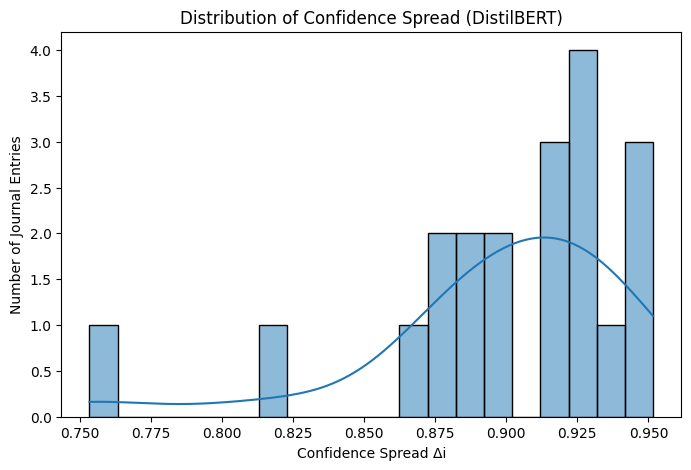

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(distil_probs_df, x="confidence_spread", bins=20, kde=True)
plt.xlabel("Confidence Spread Δi")
plt.ylabel("Number of Journal Entries")
plt.title("Distribution of Confidence Spread (DistilBERT)")
plt.show()


### RoBERTa

In [45]:
import numpy as np
import pandas as pd

# Example: DistilBERT journal probs
roberta_probs_df = pd.read_csv("data/Emotion NLP/results/roberta-journal_predictions.csv")

# Only keep probability columns
prob_cols = [col for col in roberta_probs_df.columns if col.startswith("prob_")]

# Compute confidence spread
roberta_probs_df["confidence_spread"] = roberta_probs_df[prob_cols].max(axis=1) - roberta_probs_df[prob_cols].min(axis=1)

# Quick stats
print(roberta_probs_df["confidence_spread"].describe())

# Optionally bucket them
def bucket_spread(val):
    if val > 0.7:
        return "High confidence / Clear"
    elif val > 0.4:
        return "Moderate confidence / Mixed"
    else:
        return "Low confidence / Ambiguous"

roberta_probs_df["confidence_bucket"] = roberta_probs_df["confidence_spread"].apply(bucket_spread)

# Save results
roberta_probs_df.to_csv("data/Emotion NLP/results/distilbert_journal_confidence.csv", index=False)


count    20.000000
mean      0.840587
std       0.121108
min       0.591004
25%       0.752900
50%       0.890112
75%       0.938282
max       0.968284
Name: confidence_spread, dtype: float64


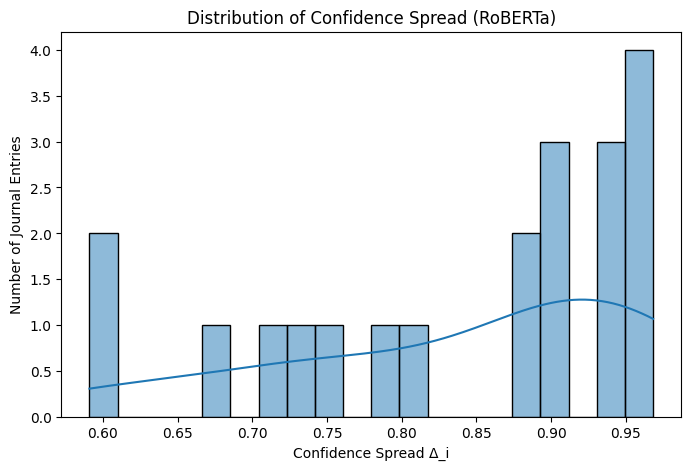

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(roberta_probs_df, x="confidence_spread", bins=20, kde=True)
plt.xlabel("Confidence Spread Δi")
plt.ylabel("Number of Journal Entries")
plt.title("Distribution of Confidence Spread (RoBERTa)")
plt.show()


Bucket A - High confidence, plausible  
Bucket B - High confidence, wrong  
Bucket C - Low confidence or ambigious

DistilBERT
| Bucket | Text | Model behaviour | Rationale |
| - | - | - | - |
| A | I felt tired even after sleeping. Emotionally drained is the only way I can describe it | Sadness (0.999) | Clear match between text and prediction |
| A | There was a moment today where I felt calm. It didn’t last long, but it reminded me that calm is still possible | Joy (0.998) | Calm plausibly mapped to positive affect |
| A | It felt uncomfortable to sit with my emotions instead of distracting myself, but I tried anyway | Fear (0.996) | Emotional discomfort reasonably interpreted |
| B | Today felt heavier than I expected. I kept replaying the conversation in my head, wondering if I said too much or not enough | Fear, sadness, anger, joy all high | Overconfident multi-label prediction |
| B | Some feelings are hard to name. I know something is there, but I can’t quite explain it. | Fear, anger, joy all high | Explicit ambiguity ignored |
| B | I noticed a pattern in my reactions today. I get defensive when I feel misunderstood. | Sadness, fear, anger high | Introspection treated as crisis |
| C | I noticed how tense my body felt this morning. My shoulders were tight, and I struggled to slow my breathing. | Fear dominant | Somatic stress ambiguous |
| C | There was a sense of restlessness throughout the day, like I couldn’t fully settle into anything. | Fear dominant | Restlessness confused with fear |
| C | I'm not sure what I was feeling exactly, just that it stayed with me longer than I expected. | Joy dominant | Confidence contradicts uncertainty |


RoBERTa
| Bucket | Text | Model behaviour | Rationale |
| - | - | - | - |
| A | I felt frustrated during the session, but I didn’t say it out loud. I’m not sure why I held back. | Anger (0.921) | Explicit emotion correctly detected |
| A | I felt tired even after sleeping. Emotionally drained is the only way I can describe it | Sadness (0.979) | Clear emotional exhaustion |
| A | There was a quiet sense of relief when I finally had time alone this evening. | Joy, optimism high | Appropriate positive affect |
| B | Today felt heavier than I expected. I kept replaying the conversation in my head, wondering if I said too much or not enough | Fear (0.893) | Rumination ≠ fear |
| B | Today wasn’t terrible, but it also wasn’t good. It just felt flat. | Sadness, disgust high | Neutral affect over-interpreted |
| B | Some feelings are hard to name. I know something is there, but I can’t quite explain it. | Sadness high | Uncertainty ignored |
| C | I caught myself overthinking small interactions today, even though nothing objectively bad happened. | Sadness, optimism mixed | No dominant signal |
| C | Part of me wanted reassurance, but another part didn’t want to ask for it. | Sadness moderate | Vulnerability ambiguous |
| C | I'm not sure what I was feeling exactly, just that it stayed with me longer than I expected. | Anticipation weak | Low-confidence diffuse emotion |
